In [1]:
from brian2 import *
from random import randrange
from collections import Counter
import math

In [2]:
def input_current_generator(max_I,delta_time,duration):
    output = TimedArray([(random() * max_I) * namp for i in range(int(duration/delta_time))],delta_time)
    return output

In [204]:
def simulate_decision(each_ex_num = 400 , inh_num = 300 , Resistance = 2*Mohm , max_I = 30 , ex1_tau=10 , ex2_tau=10 , inh_tau=10
                     ,pi_e1 = 0.3 , pi_e2 = 0.3 , pe1_e1 = 1 , pe2_e2 = 1 , pe1_i = 1 , pe2_i = 1
                     ,input_wi_e1 = -10*mV ,input_wi_e2 = -10*mV, input_we1_e1 = 100*mV ,input_we2_e2 = 100*mV , input_we1_i = 10*mV, input_we2_i = 10*mV):
    
    start_scope()
    N = each_ex_num * 2 + inh_num
    duration = 100 * ms
    delta_time = 1 * ms
    u_rest = -70 * mV
    threshold = -55 * mV
    
    Random_I = input_current_generator(max_I,delta_time,duration)

    ex_eqs = '''
        du/dt = -(u-u_rest)/tau + Resistance * Random_I(t)/tau : volt
        tau : second
    '''
    inh_eqs = '''
        du/dt = -(u-u_rest)/tau + Resistance * 0*namp /tau : volt
        tau : second
    '''
    
    excitatory_neurons = NeuronGroup(2 * each_ex_num , ex_eqs , threshold='u>threshold' , reset='u=u_rest' , method='linear')
    inhibitory_neurons = NeuronGroup(inh_num , inh_eqs , threshold='u>threshold' , reset='u=u_rest' , method='linear')
    
    excitatory_neurons_1 = excitatory_neurons[:each_ex_num]
    excitatory_neurons_1.u = randrange(-75,-65) * mV
    excitatory_neurons_1.tau = ex1_tau * ms
    
    excitatory_neurons_2 = excitatory_neurons[each_ex_num:]
    excitatory_neurons_2.u = randrange(-75,-65) * mV
    excitatory_neurons_2.tau = ex2_tau * ms
    
    inhibitory_neurons.u = randrange(-75,-65) * mV
    inhibitory_neurons.tau = inh_tau * ms
    
    e1_e1 = Synapses(excitatory_neurons_1, excitatory_neurons_1,'we1_e1 : volt', on_pre='u_post += we1_e1')
    e1_e1.connect(condition='i!=j', p=pe1_e1)
    e1_e1.we1_e1 = input_we1_e1 / math.sqrt(each_ex_num * pe1_e1)
    
    e2_e2 = Synapses(excitatory_neurons_2, excitatory_neurons_2,'we2_e2 : volt', on_pre='u_post += we2_e2')
    e2_e2.connect(condition='i!=j', p=pe2_e2)
    e2_e2.we2_e2 = input_we2_e2 / math.sqrt(each_ex_num * pe2_e2)
    
    e1_i = Synapses(excitatory_neurons_1, inhibitory_neurons,'we1_i : volt', on_pre='u_post += we1_i')
    e1_i.connect(condition='i!=j', p=pe1_i)
    e1_i.we1_i = input_we1_i / math.sqrt(inh_num * pe1_i)
     
    e2_i = Synapses(excitatory_neurons_2, inhibitory_neurons,'we2_i : volt', on_pre='u_post += we2_i')
    e2_i.connect(condition='i!=j', p=pe2_i)
    e2_i.we2_i = input_we2_i / math.sqrt(inh_num * pe2_i)  
    
    i_e1 = Synapses(inhibitory_neurons, excitatory_neurons_1,'wi_e1 : volt', on_pre='u_post += wi_e1')
    i_e1.connect(condition='i!=j', p=pi_e1)
    i_e1.wi_e1 = input_wi_e1 / math.sqrt(each_ex_num * pi_e1)
    
    i_e2 = Synapses(inhibitory_neurons, excitatory_neurons_2,'wi_e2 : volt', on_pre='u_post += wi_e2')
    i_e2.connect(condition='i!=j', p=pi_e2)
    i_e2.wi_e2 = input_wi_e2 / math.sqrt(each_ex_num * pi_e2)
    
    ex_State_M = StateMonitor(excitatory_neurons, 'u', record=0)
    ex_Spike_M = SpikeMonitor(excitatory_neurons)
    inh_State_M = StateMonitor(inhibitory_neurons, 'u', record=0)
    inh_Spike_M = SpikeMonitor(inhibitory_neurons)
    
    run(duration)
    
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(5, 4)
    axs0 = fig.add_subplot(gs[:-3, :])
    axs1 = fig.add_subplot(gs[-3, :])
    axs2 = fig.add_subplot(gs[-2, :])
    axs3 = fig.add_subplot(gs[-1, :])
    
    
    fig.set_figwidth(18)
    fig.set_figheight(14)
    axs0.plot(ex_Spike_M.t/ms, ex_Spike_M.i, '.k', ms=1)
    axs0.plot(inh_Spike_M.t/ms, [i+2*each_ex_num for i in inh_Spike_M.i], '.k', ms=1)
    
    axs0.set_ylabel('neuron number')
    axs0.grid()
    excitatory1_spike_times = sorted(list(flatten([list(list(ex_Spike_M.all_values()['t'].get(i))/ms) for i in range(N) if i<=each_ex_num-1])))
    excitatory2_spike_times = sorted(list(flatten([list(list(ex_Spike_M.all_values()['t'].get(i))/ms) for i in range(N) if 2*each_ex_num - 1>i>each_ex_num-1])))
    inhibitory_spike_times = sorted(list(flatten([list(list(inh_Spike_M.all_values()['t'].get(i))/ms) for i in range(inh_num)])))
    
    axs1.plot(list(Counter(excitatory1_spike_times).keys()) ,[x*100/each_ex_num for x in list(Counter(excitatory1_spike_times).values())],label = 'excitatory1')
    axs1.plot(list(Counter(excitatory2_spike_times).keys()),[x*100/each_ex_num for x in list(Counter(excitatory2_spike_times).values())],label = 'excitatory2')
    axs1.set_ylabel('% of spiking excitatory neurons')
    axs1.legend()
    axs1.grid()
    
    axs2.plot(list(Counter(inhibitory_spike_times).keys()),[x*100/inh_num for x in list(Counter(inhibitory_spike_times).values())],label = 'inhibitory',color='green')
    axs2.set_ylabel('% of spiking inhibitory neurons')
    axs2.legend()
    axs2.grid()
    

    axs0.set_title('#each excitatory ='+str(each_ex_num)+' | #inhibitory ='+str(inh_num)+' | Resistance ='+str(Resistance)+' | excitatory1_tau ='+str(excitatory_neurons_1.tau[0])+' | excitatory2_tau ='+str(excitatory_neurons_2.tau[0])
                  +' | inhibitory_tau ='+str(inhibitory_neurons.tau[0]) +' | Max_I ='+str(max_I) + '\n'
                  +' | pi_e1 ='+str(pi_e1)+' | pi_e2 ='+str(pi_e2)+' | pe1_e1 ='+str(pe1_e1)+' | pe2_e2 ='+str(pe2_e2)+' | pe1_i ='+str(pe1_i)+' | pe2_i ='+str(pe2_i) + '\n'
                  +' | wi_e1 ='+str(input_wi_e1)+' | wi_e2 ='+str(input_wi_e2)+' | we1_e1 ='+str(input_we1_e1)+' | we2_e2 ='+str(input_we2_e2)+' | we1_i ='+str(input_we1_i)+' | we2_i ='+str(input_we2_i))
    axs3.plot(np.arange(duration/ms),list(Random_I.values*1000000000))
    axs3.set_ylabel('amplitude (namp)')
    axs3.set_xlabel('time (ms)')
    axs3.grid()


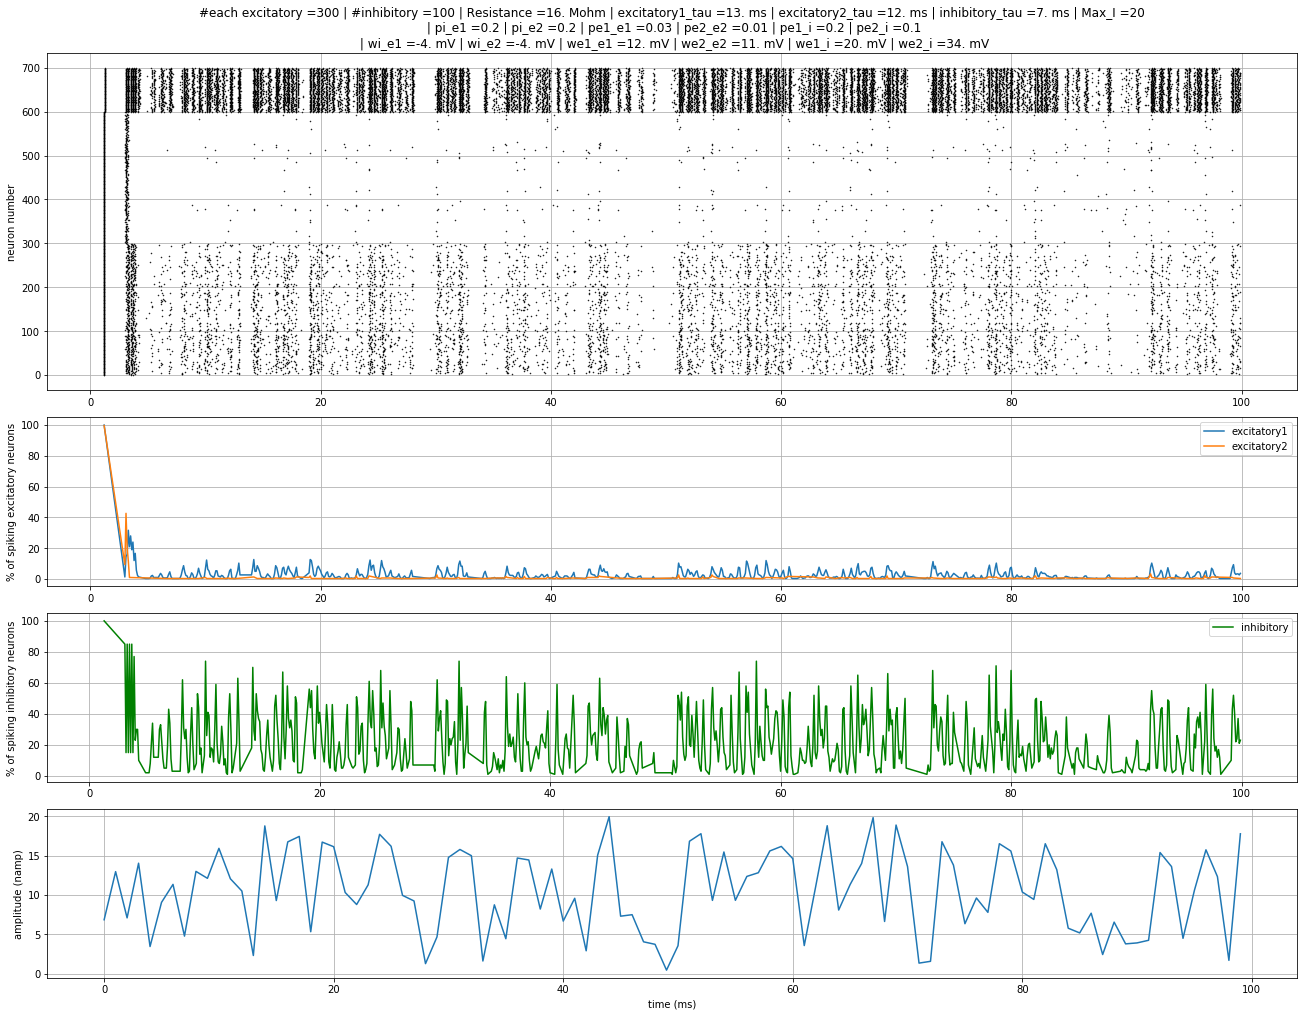

In [174]:
simulate_decision(each_ex_num = 300 , inh_num = 100 , Resistance = 16*Mohm , max_I = 20
                     ,pi_e1 = 0.2 , pi_e2 = 0.2 , pe1_e1 = 0.03 , pe2_e2 = 0.01 , pe1_i = 0.2 , pe2_i = 0.1
                     ,input_wi_e1 = -4*mV ,input_wi_e2 = -4*mV, input_we1_e1 = 12*mV ,input_we2_e2 = 11*mV , input_we1_i = 20*mV, input_we2_i = 34*mV)

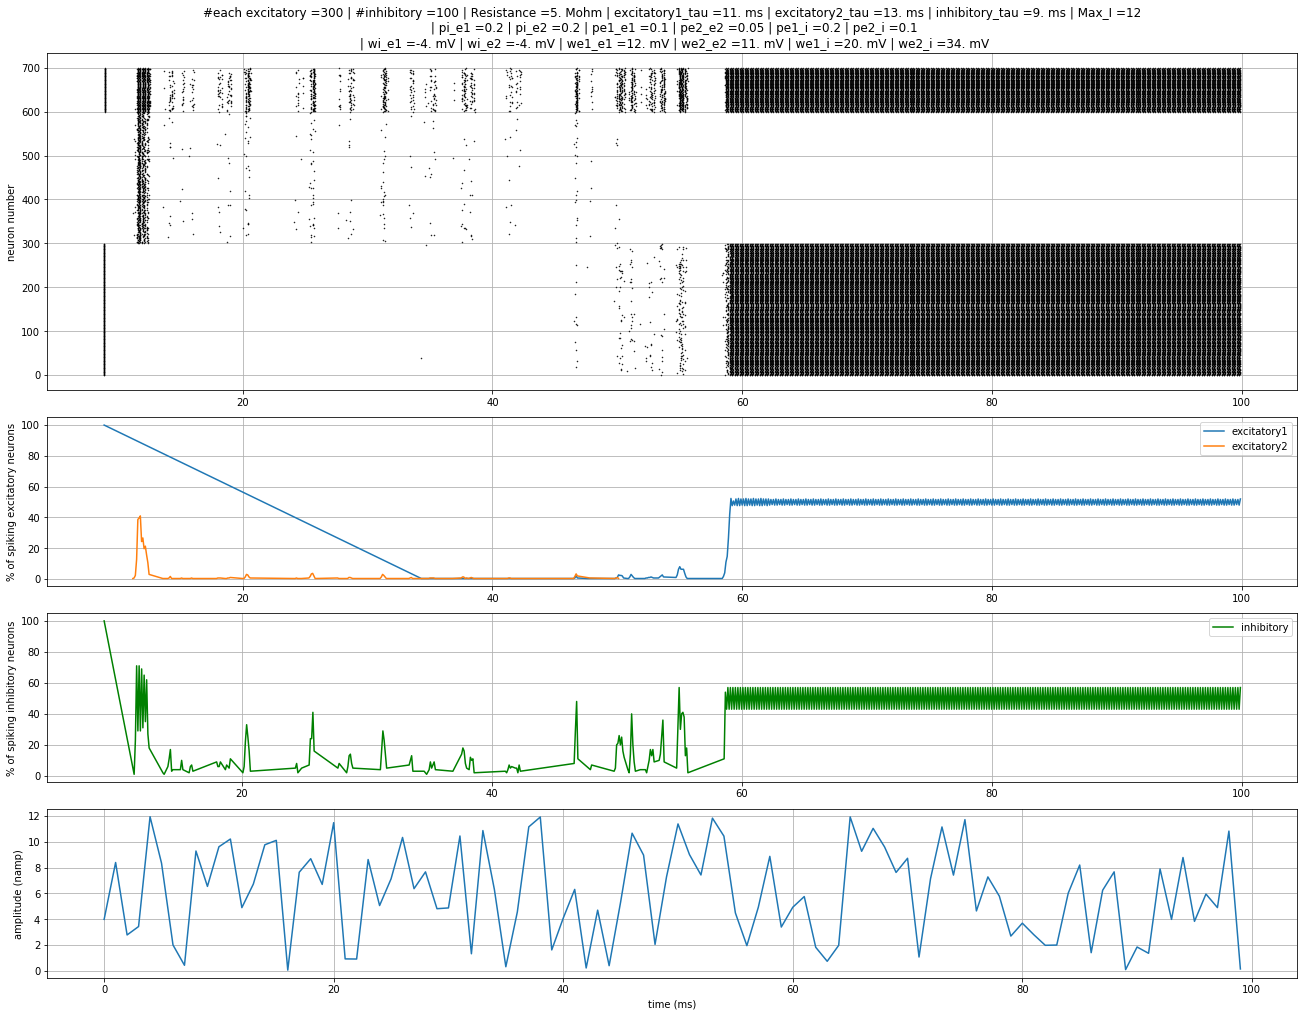

In [177]:
simulate_decision(each_ex_num = 300 , inh_num = 100 , Resistance = 5*Mohm , max_I = 12
                     ,pi_e1 = 0.2 , pi_e2 = 0.2 , pe1_e1 = 0.1 , pe2_e2 = 0.05 , pe1_i = 0.2 , pe2_i = 0.1
                     ,input_wi_e1 = -4*mV ,input_wi_e2 = -4*mV, input_we1_e1 = 12*mV ,input_we2_e2 = 11*mV , input_we1_i = 20*mV, input_we2_i = 34*mV)

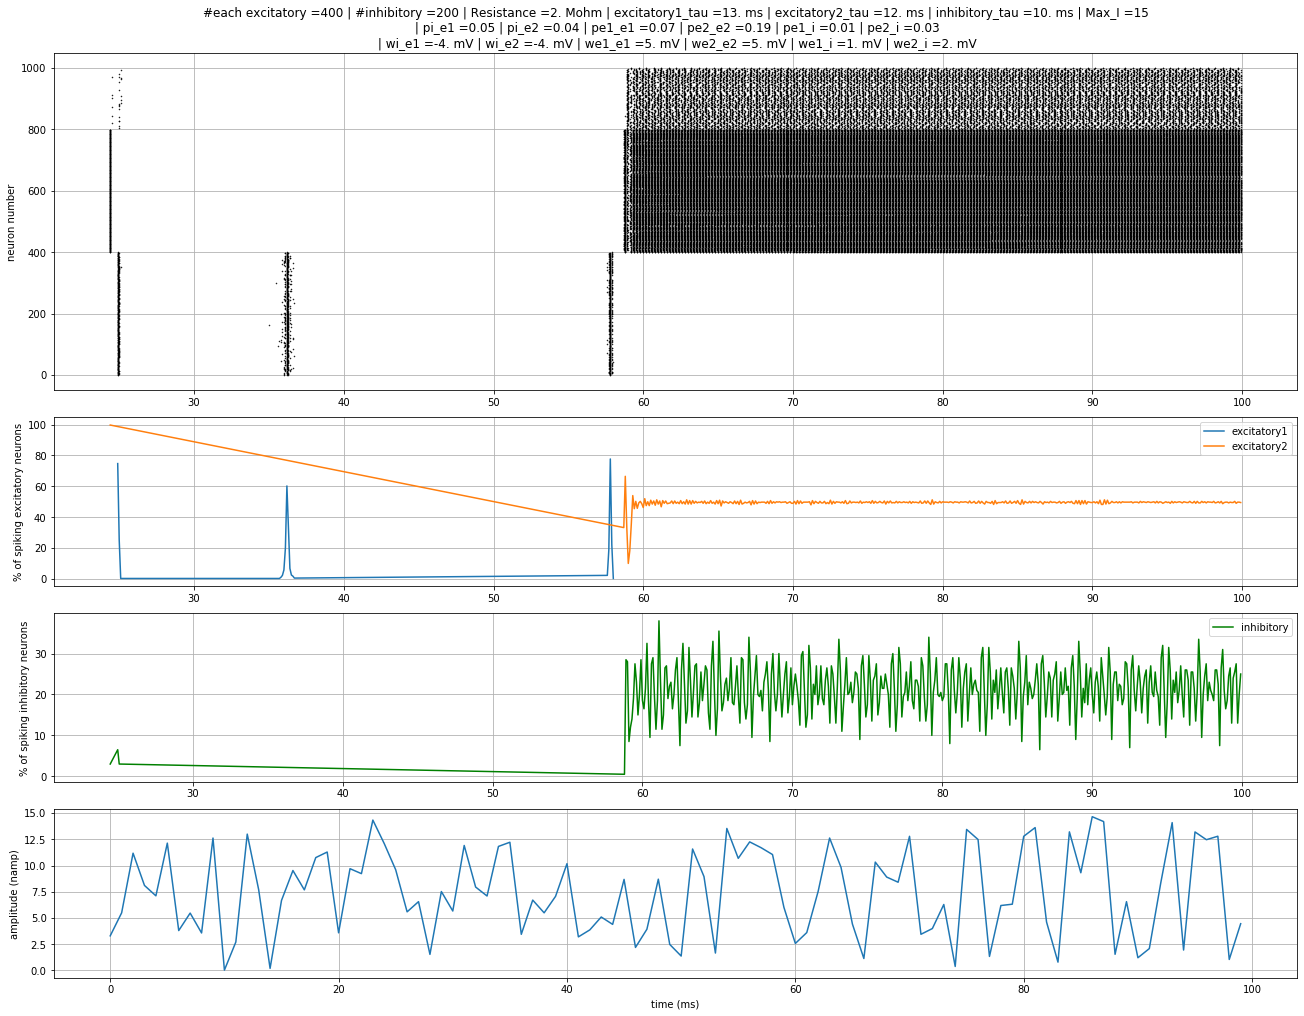

In [208]:
simulate_decision(each_ex_num = 400 , inh_num = 200 , Resistance = 2*Mohm , max_I = 15 , ex1_tau=13 , ex2_tau=12 , inh_tau=10
                     ,pi_e1 = 0.05 , pi_e2 = 0.04 , pe1_e1 = 0.07 , pe2_e2 = 0.19 , pe1_i = 0.01 , pe2_i = 0.03
                     ,input_wi_e1 = -4*mV ,input_wi_e2 = -4*mV, input_we1_e1 = 5*mV ,input_we2_e2 = 5*mV , input_we1_i = 1*mV, input_we2_i = 2*mV)

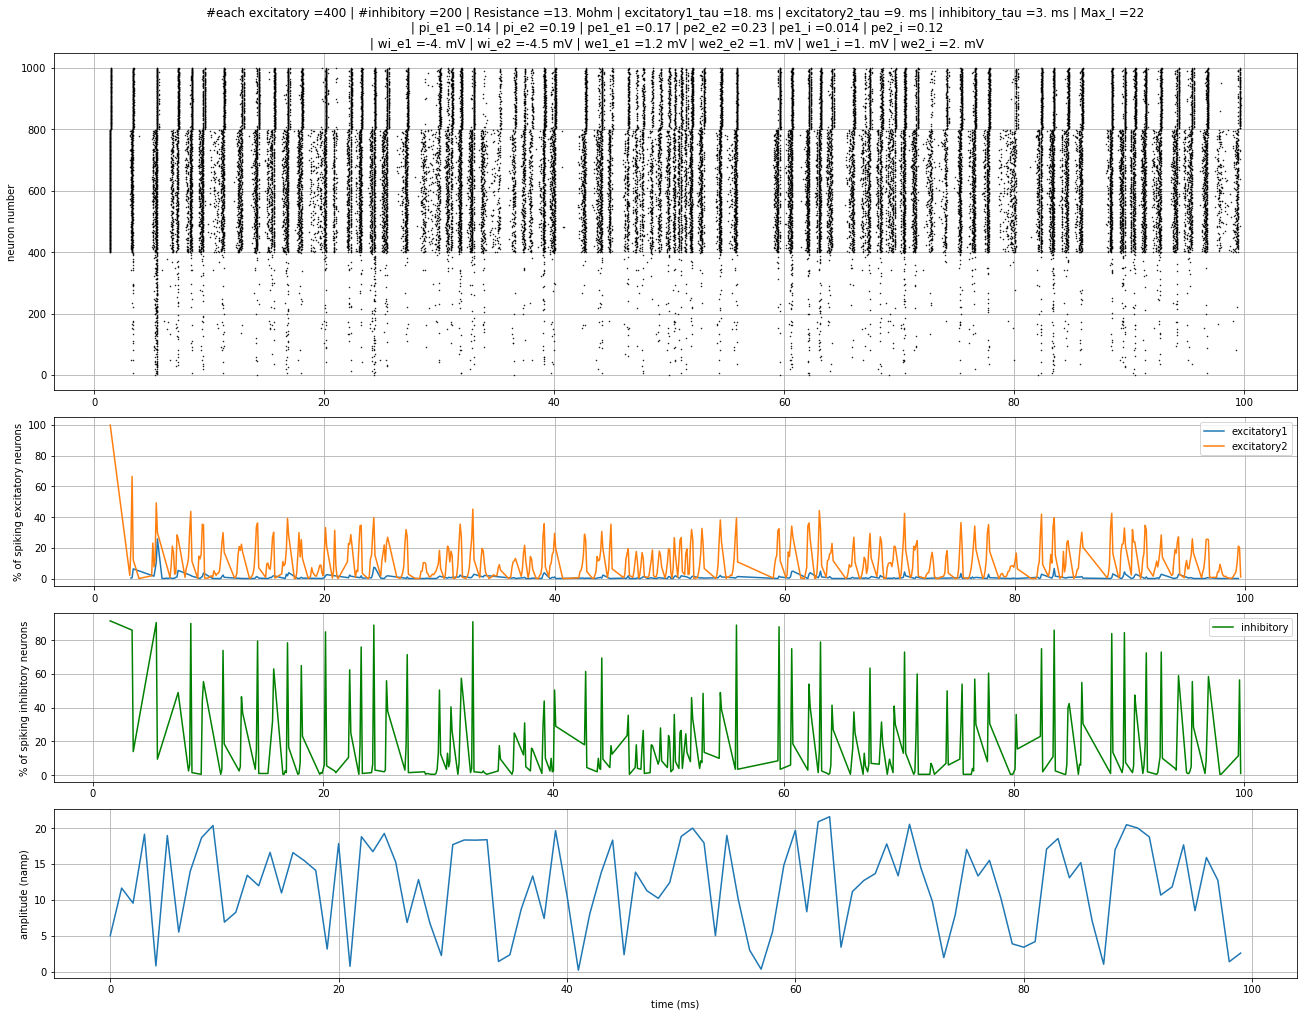

In [212]:
simulate_decision(each_ex_num = 400 , inh_num = 200 , Resistance = 13*Mohm , max_I = 22 , ex1_tau=18 , ex2_tau=9 , inh_tau=3
                     ,pi_e1 = 0.14 , pi_e2 = 0.19 , pe1_e1 = 0.17 , pe2_e2 = 0.23 , pe1_i = 0.014 , pe2_i = 0.12
                     ,input_wi_e1 = -4*mV ,input_wi_e2 = -4.5*mV, input_we1_e1 = 1.2*mV ,input_we2_e2 = 1*mV , input_we1_i = 1*mV, input_we2_i = 2*mV)

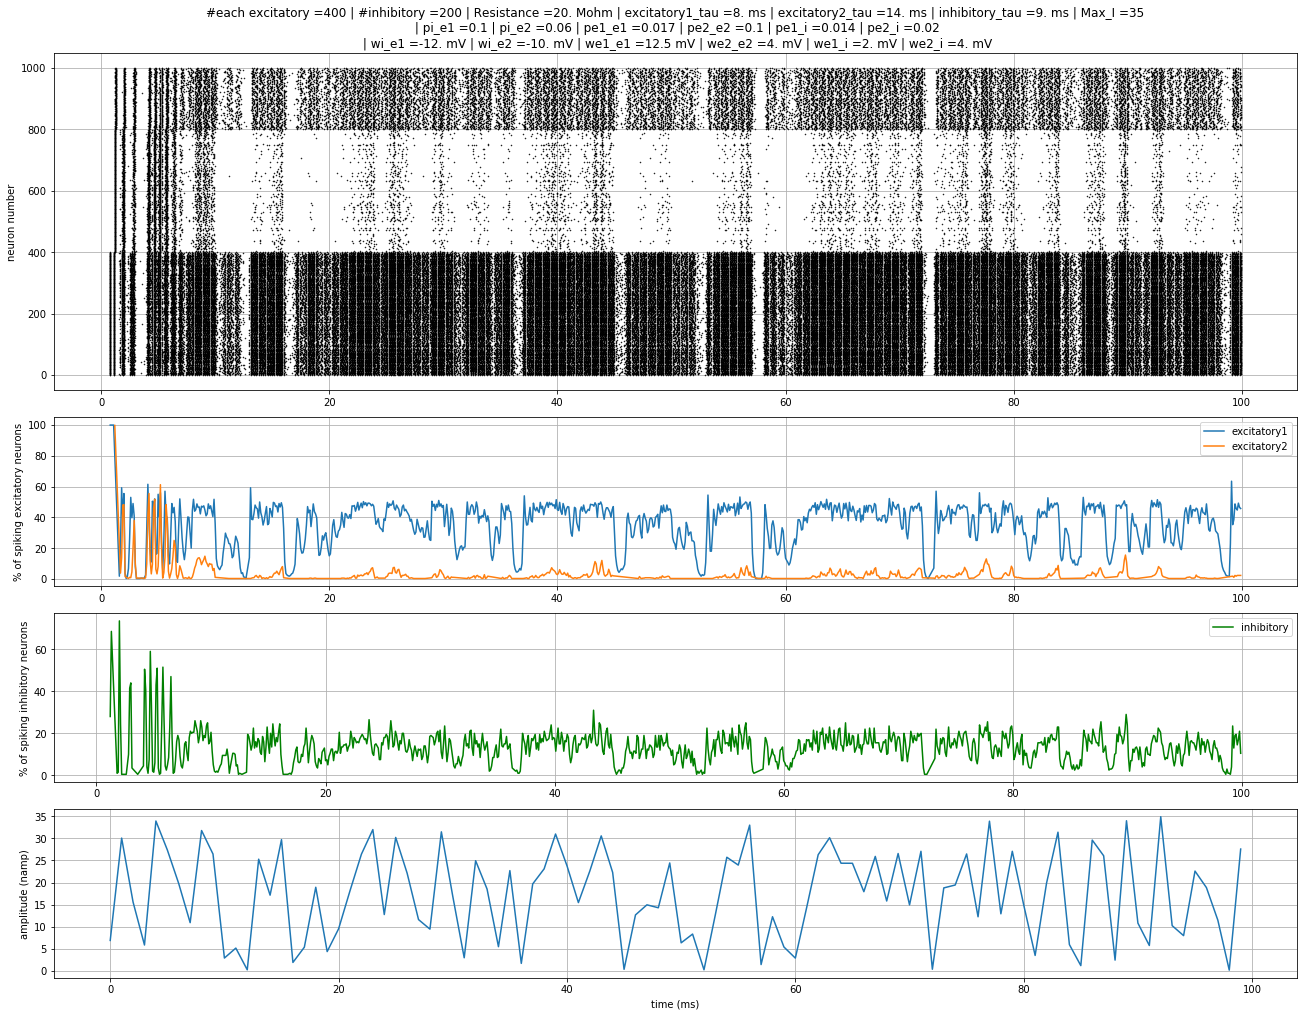

In [224]:

simulate_decision(each_ex_num = 400 , inh_num = 200 , Resistance = 20*Mohm , max_I = 35 , ex1_tau=8 , ex2_tau=14 , inh_tau=9
                     ,pi_e1 = 0.1 , pi_e2 = 0.06 , pe1_e1 = 0.017 , pe2_e2 = 0.1 , pe1_i = 0.014 , pe2_i = 0.02
                     ,input_wi_e1 = -12*mV ,input_wi_e2 = -10*mV, input_we1_e1 = 12.5*mV ,input_we2_e2 = 4*mV , input_we1_i = 2*mV, input_we2_i = 4*mV)

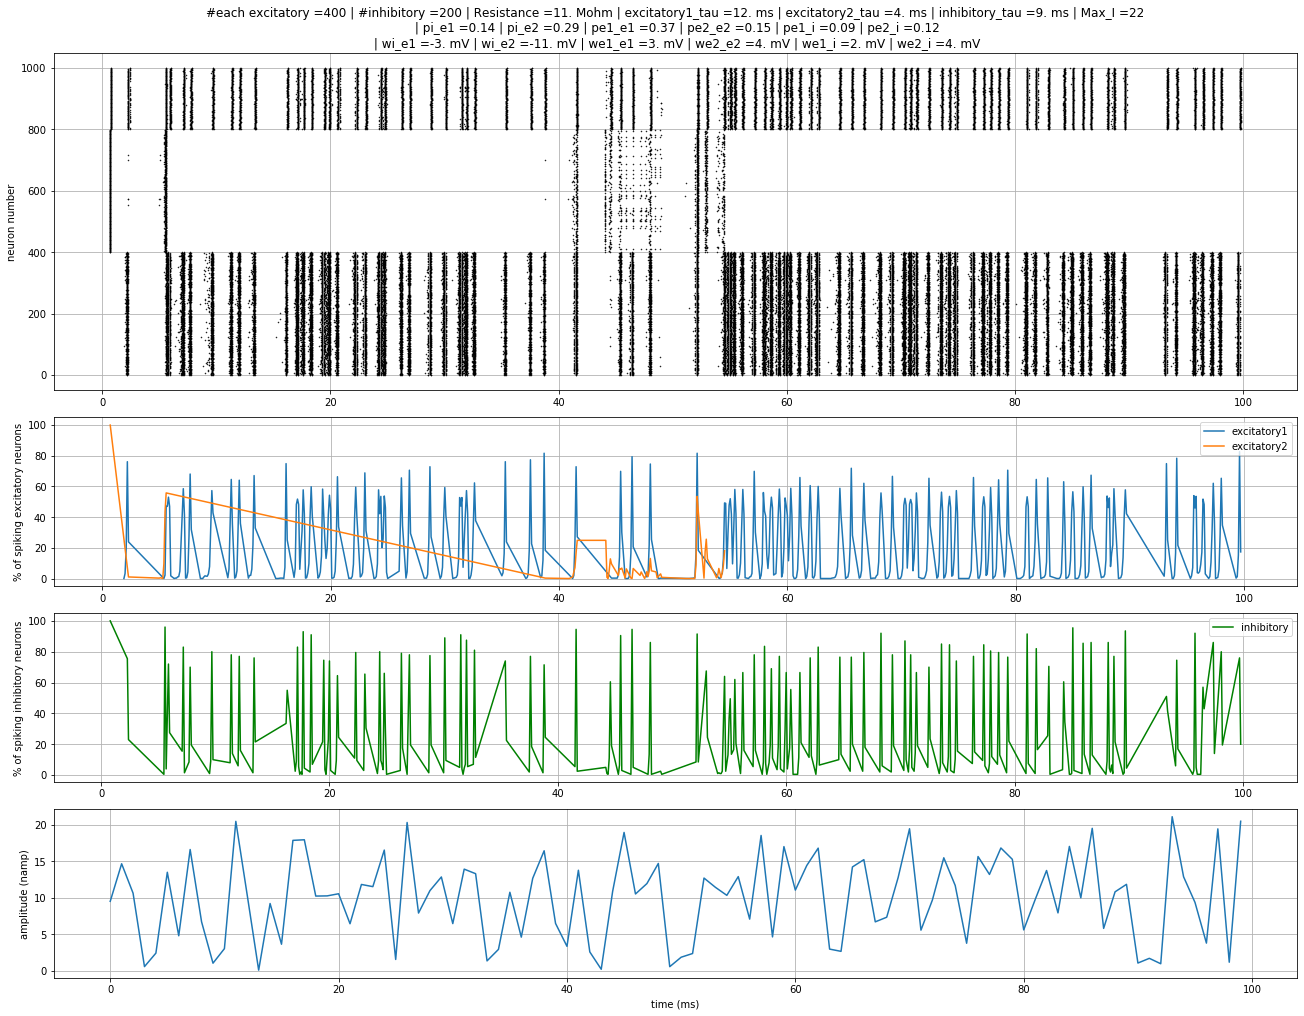

In [236]:

simulate_decision(each_ex_num = 400 , inh_num = 200 , Resistance = 11*Mohm , max_I = 22 , ex1_tau=12 , ex2_tau=4 , inh_tau=9
                     ,pi_e1 = 0.14 , pi_e2 = 0.29 , pe1_e1 = 0.37 , pe2_e2 = 0.15 , pe1_i = 0.09 , pe2_i = 0.12
                     ,input_wi_e1 = -3*mV ,input_wi_e2 = -11*mV, input_we1_e1 = 3*mV ,input_we2_e2 = 4*mV , input_we1_i = 2*mV, input_we2_i = 4*mV)